In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 28 09:43:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
import random
import os
import io
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, DistilBertForSequenceClassification,get_linear_schedule_with_warmup
from tqdm import tqdm, trange,tnrange,tqdm_notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00


In [ ]:
# identify GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
SEED = 19
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/a_raw_labeled/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/a_raw_labeled/test.csv')

In [ ]:
df_train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
pd.set_option('display.max_colwidth', 160)
df_train.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [ ]:
df_train['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
df_train['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [ ]:
df_train = df_train[~df_train['sentiment'].isnull()]
#df_test = df_test[~df_test['sentiment'].isnull()]

In [ ]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]    
    return ' '.join(stems)

def tokenize(text):
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)    
    return tokens

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_train['sentiment_1'] = labelencoder.fit_transform(df_train['sentiment'])

In [ ]:
df_train[['sentiment','sentiment_1']].drop_duplicates(keep='first')

,sentiment,sentiment_1
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
df_train.rename(columns={'sentiment_1':'label'},inplace=True)

In [ ]:
## create label and sentence list
sentences = df_train.text.values
print("Distribution of data based on labels: ",df_train.label.value_counts())
MAX_LEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Distribution of data based on labels:  2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: label, dtype: int64


In [ ]:
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,padding='longest',truncation=True) for sent in sentences]

In [ ]:
labels = df_train.label.values
print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])
attention_masks = []
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Actual sentence before tokenization:  im grabbing a minute to post i feel greedy wrong
Encoded Input from dataset:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# convert the input sequences to PyTorch tensors
train_inputs = [torch.tensor(seq) for seq in train_inputs]
validation_inputs = [torch.tensor(seq) for seq in validation_inputs]

# pad input sequences to the same length
train_inputs = pad_sequence(train_inputs, batch_first=True)
validation_inputs = pad_sequence(validation_inputs, batch_first=True)

# pad the attention masks to the same length
train_masks = pad_sequence([torch.tensor(seq) for seq in train_masks], batch_first=True)
validation_masks = pad_sequence([torch.tensor(seq) for seq in validation_masks], batch_first=True)

# convert all data into torch tensors, required data type for our model
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

print(train_inputs.shape) # should print [batch_size, max_seq_length]
print(train_masks.shape) # should print [batch_size, max_seq_length]
print(train_labels.shape) # should print [batch_size]

torch.Size([14400, 87])
torch.Size([14400, 87])
torch.Size([14400])


In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader to save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# Load DistilBertForSequenceClassification, the pretrained DistilBERT model with a single linear classification layer on top.
num_labels = 6
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels).to(device)
lr = 2e-5
adam_epsilon = 1e-8
epochs = 10
num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs
optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [ ]:
train_data[0]

(tensor([  101,  1045,  2001,  2025,  5204,  1997,  2010,  2391,  1997,  3193,
          2004,  1037,  2317,  2647,  2040,  2018, 10607,  2023,  4440,  2004,
          1037, 29362,  1997,  1037,  5593,  3959,  2021,  2672,  2138,  1997,
          2023,  7073,  1045,  2001,  2583,  2000,  2514,  1996, 13800,  6440,
          2075,  9388, 27663,  6322,  1997,  8438,  2015, 18101,  9680,  6305,
          3012,  1998, 22040,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
## Store our loss and accuracy for plotting
train_loss_set = []
learning_rate = []

# Gradients gets accumulated by default
model.zero_grad()

# tnrange is a tqdm wrapper around normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  # Calculate total loss for this epoch
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    #outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    # Backward pass
    loss.backward()
    
    # Clip the norm of the gradients to 1.0
    # Gradient clipping is not in AdamW anymore
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update learning rate schedule
    scheduler.step()

    # Clear the previous accumulated gradients
    optimizer.zero_grad()
    
    # Update tracking variables
    batch_loss += loss.item()

  # Calculate the average loss over the training data.
  avg_train_loss = batch_loss / len(train_dataloader)

  #store the current learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions      
      logits = model(b_input_ids, attention_mask=b_input_mask)
      #logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

<ipython-input-25-bfac8c146db0>:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1,epochs+1,desc='Epoch'):


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.8e-05

	Average Training loss: 0.3996315637148089

	Validation Accuracy: 0.915625

	Validation MCC Accuracy: 0.8903684170351529
<====================== Epoch 2 ======================>

	Current Learning rate:  1.6000000000000003e-05

	Average Training loss: 0.13036992336933811

	Validation Accuracy: 0.925625

	Validation MCC Accuracy: 0.9019339253633241
<====================== Epoch 3 ======================>

	Current Learning rate:  1.4e-05

	Average Training loss: 0.09195363755751815

	Validation Accuracy: 0.939375

	Validation MCC Accuracy: 0.9195425546828221
<====================== Epoch 4 ======================>

	Current Learning rate:  1.2e-05

	Average Training loss: 0.07178548748397992

	Validation Accuracy: 0.926875

	Validation MCC Accuracy: 0.9043772406987794
<====================== Epoch 5 ======================>

	Current Learning rate:  1e-05

	Average Training loss: 0.05004535517500092



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
## emotion labels
label2int = {
  "anger": 0,
  "fear": 1,
  "joy": 2,
  "love": 3,
  "sadness": 4,
  "surprise": 5
}

In [ ]:
# # Define a modified label2int dictionary with 5 keys (one for each emotion label)
# label2int = {
#     "anger": 0,
#     "fear": 1,
#     "joy": 2,
#     "love": 3,
#     "sadness": 4
# }

In [ ]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=2))

              precision    recall  f1-score   support

       anger       1.00      0.75      0.86         4
        fear       0.67      0.50      0.57         4
         joy       1.00      0.91      0.95        11
        love       0.67      1.00      0.80         2
     sadness       0.83      1.00      0.91        10
    surprise       1.00      1.00      1.00         1

    accuracy                           0.88        32
   macro avg       0.86      0.86      0.85        32
weighted avg       0.89      0.88      0.87        32



Normalized confusion matrix
[[0.75       0.25       0.         0.         0.         0.        ]
 [0.         0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.90909091 0.09090909 0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


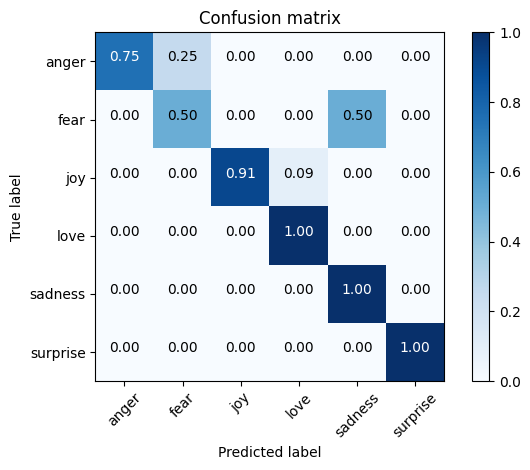

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values)
classes = label2int.keys()
plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix')

In [ ]:
model_save_folder = 'model/'
tokenizer_save_folder = 'tokenizer/'

path_model = '/content/drive/MyDrive/DLBBT01/src/3.code_model_deploy/distilbert/' + model_save_folder
path_tokenizer = '/content/drive/MyDrive/DLBBT01/src/3.code_model_deploy/distilbert/' + tokenizer_save_folder

##create the dir
os.makedirs(path_model, exist_ok=True)
os.makedirs(path_tokenizer, exist_ok=True)

### Now let's save our model and tokenizer to a directory
model.save_pretrained(path_model)
tokenizer.save_pretrained(path_tokenizer)

model_save_name = 'fineTuneModel.pt'
path = path_model + model_save_name
torch.save(model.state_dict(), path)


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification